In [1]:
#IMPORT KNJIŽNICA I ARHITEKTURA MODELA

#Import knjižnica
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
import matplotlib.pyplot as plt

#Klasa za uzorkovanje iz latentnog prostora
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
latent_dim = 2

#Arhitektura enkodera
encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Arhitektura dekodera
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

#Klasa VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + 0.27 * kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + 0.27 * kl_loss

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 88, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 44, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d[0][0]']          
                                                                                            

In [2]:
#OBRADA PODATAKA

from sklearn.preprocessing import MinMaxScaler

#Učitavanje podataka i podjela na skupove za trening i testiranje
features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(
                                    features, labels, test_size=0.2, random_state=42)

#Odvajanje sekvenci peptida od ostatka podataka
x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]

#Odvajanje izračunatih značajki peptida
x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

#Normalizacija podataka
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

#Prilagođavanje dimenzionalnosti podataka
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [3]:
#OPTIMIZACIJA HIPERPARAMETARA

#Prostor pretrage
learn_rate = [0.001, 0.005, 0.008, 0.01]
batch_size = [32, 64, 128, 256]

param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

#Petlje u kojima se obavlja testiranje svih kombinacija hiperparametara iz prostora pretrage
for lr in learn_rate:
    for bs in batch_size:
        print("Learning rate: ", lr)
        print("Batch size: ", bs)
        
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
        
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
        early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)
        
        vae.fit(x_train, batch_size=bs, epochs=30, validation_split = 0.2, 
                callbacks=[reduce_lr, early_stop])

        score = vae.evaluate(x_train)
        print(score)

        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

#Ispis najboljih hiperparametara  
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

#Spremanje najboljih hiperparametara u varijable za daljnje korištenje
lr = best_params['learn_rate']
bs = best_params['batch_size']

Learning rate:  0.001
Batch size:  32
Epoch 1/30
210/210 [==============================] - 3s 8ms/step - loss: 1.3721 - reconstruction_loss: 1.1760 - kl_loss: 0.0173 - val_total_loss: 1.0439 - val_reconstruction_loss: 1.0357 - val_kl_loss: 0.0303 - lr: 0.0010
Epoch 2/30
210/210 [==============================] - 1s 6ms/step - loss: 1.0019 - reconstruction_loss: 0.9618 - kl_loss: 0.0690 - val_total_loss: 0.9882 - val_reconstruction_loss: 0.9400 - val_kl_loss: 0.1783 - lr: 0.0010
Epoch 3/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9526 - reconstruction_loss: 0.8890 - kl_loss: 0.2097 - val_total_loss: 0.8649 - val_reconstruction_loss: 0.7708 - val_kl_loss: 0.3483 - lr: 0.0010
Epoch 4/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9406 - reconstruction_loss: 0.8502 - kl_loss: 0.2982 - val_total_loss: 0.9233 - val_reconstruction_loss: 0.8106 - val_kl_loss: 0.4171 - lr: 0.0010
Epoch 5/30
210/210 [==============================] - 1s 6ms/step - lo

105/105 [==============================] - 1s 9ms/step - loss: 0.8783 - reconstruction_loss: 0.6876 - kl_loss: 0.6689 - val_total_loss: 0.7327 - val_reconstruction_loss: 0.5184 - val_kl_loss: 0.7934 - lr: 0.0010
Epoch 7/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8828 - reconstruction_loss: 0.6886 - kl_loss: 0.6679 - val_total_loss: 0.8311 - val_reconstruction_loss: 0.6128 - val_kl_loss: 0.8085 - lr: 0.0010
Epoch 8/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8588 - reconstruction_loss: 0.6932 - kl_loss: 0.6452 - val_total_loss: 0.7771 - val_reconstruction_loss: 0.5847 - val_kl_loss: 0.7126 - lr: 0.0010
Epoch 9/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8692 - reconstruction_loss: 0.6861 - kl_loss: 0.6647 - val_total_loss: 0.8408 - val_reconstruction_loss: 0.6326 - val_kl_loss: 0.7709 - lr: 0.0010
Epoch 10/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8636 - reconstruction_loss: 0.6836 - k

Epoch 11/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8476 - reconstruction_loss: 0.6730 - kl_loss: 0.6812 - val_total_loss: 0.8693 - val_reconstruction_loss: 0.6714 - val_kl_loss: 0.7332 - lr: 0.0010
Epoch 12/30
53/53 [==============================] - 1s 16ms/step - loss: 0.8607 - reconstruction_loss: 0.6716 - kl_loss: 0.6760 - val_total_loss: 0.9609 - val_reconstruction_loss: 0.7462 - val_kl_loss: 0.7953 - lr: 0.0010
Epoch 13/30
53/53 [==============================] - 1s 16ms/step - loss: 0.8572 - reconstruction_loss: 0.6734 - kl_loss: 0.7004 - val_total_loss: 0.9255 - val_reconstruction_loss: 0.6901 - val_kl_loss: 0.8719 - lr: 0.0010
Epoch 14/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8598 - reconstruction_loss: 0.6711 - kl_loss: 0.6880 - val_total_loss: 0.9550 - val_reconstruction_loss: 0.7094 - val_kl_loss: 0.9099 - lr: 0.0010
Epoch 15/30
53/53 [==============================] - 1s 16ms/step - loss: 0.8474 - reconstruction_loss: 0.67

Epoch 15/30
27/27 [==============================] - 1s 28ms/step - loss: 0.8623 - reconstruction_loss: 0.6599 - kl_loss: 0.7094 - val_total_loss: 0.8228 - val_reconstruction_loss: 0.6062 - val_kl_loss: 0.8022 - lr: 0.0010
Epoch 16/30
27/27 [==============================] - 1s 27ms/step - loss: 0.8554 - reconstruction_loss: 0.6611 - kl_loss: 0.7121 - val_total_loss: 0.8885 - val_reconstruction_loss: 0.6844 - val_kl_loss: 0.7558 - lr: 0.0010
Epoch 17/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8624 - reconstruction_loss: 0.6658 - kl_loss: 0.6964 - val_total_loss: 0.8861 - val_reconstruction_loss: 0.6718 - val_kl_loss: 0.7936 - lr: 0.0010
Epoch 18/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8459 - reconstruction_loss: 0.6587 - kl_loss: 0.7010 - val_total_loss: 0.8630 - val_reconstruction_loss: 0.6525 - val_kl_loss: 0.7794 - lr: 0.0010
Epoch 19/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8571 - reconstruction_loss: 0.66

210/210 [==============================] - 1s 6ms/step - loss: 0.8613 - reconstruction_loss: 0.6941 - kl_loss: 0.6579 - val_total_loss: 0.9743 - val_reconstruction_loss: 0.7759 - val_kl_loss: 0.7346 - lr: 0.0050
Epoch 20/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8607 - reconstruction_loss: 0.6720 - kl_loss: 0.6896 - val_total_loss: 0.8535 - val_reconstruction_loss: 0.6150 - val_kl_loss: 0.8831 - lr: 0.0025
Epoch 21/30
210/210 [==============================] - 1s 7ms/step - loss: 0.8694 - reconstruction_loss: 0.6721 - kl_loss: 0.7036 - val_total_loss: 0.7138 - val_reconstruction_loss: 0.4888 - val_kl_loss: 0.8334 - lr: 0.0025
Epoch 22/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8612 - reconstruction_loss: 0.6752 - kl_loss: 0.6797 - val_total_loss: 0.8746 - val_reconstruction_loss: 0.6415 - val_kl_loss: 0.8631 - lr: 0.0025
Epoch 23/30
210/210 [==============================] - 1s 7ms/step - loss: 0.8602 - reconstruction_loss: 0.6746 - kl

Epoch 25/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8463 - reconstruction_loss: 0.6775 - kl_loss: 0.6739 - val_total_loss: 0.8928 - val_reconstruction_loss: 0.6365 - val_kl_loss: 0.9496 - lr: 0.0050
Epoch 26/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8759 - reconstruction_loss: 0.6775 - kl_loss: 0.6876 - val_total_loss: 0.7715 - val_reconstruction_loss: 0.5376 - val_kl_loss: 0.8662 - lr: 0.0050
Epoch 27/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8729 - reconstruction_loss: 0.6739 - kl_loss: 0.7019 - val_total_loss: 0.8072 - val_reconstruction_loss: 0.5899 - val_kl_loss: 0.8048 - lr: 0.0050
Epoch 28/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8634 - reconstruction_loss: 0.6712 - kl_loss: 0.6934 - val_total_loss: 0.9927 - val_reconstruction_loss: 0.7909 - val_kl_loss: 0.7475 - lr: 0.0050
Epoch 29/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8508 - reconstruction_loss:

Epoch 30/30
262/262 [==============================] - 1s 2ms/step - total_loss: 0.8382 - reconstruction_loss: 0.6521 - kl_loss: 0.6892
[0.8381789922714233, 0.6520878076553345, 0.6892266869544983]
Learning rate:  0.005
Batch size:  256
Epoch 1/30
27/27 [==============================] - 3s 36ms/step - loss: 0.8816 - reconstruction_loss: 0.6777 - kl_loss: 0.6909 - val_total_loss: 0.8392 - val_reconstruction_loss: 0.6474 - val_kl_loss: 0.7105 - lr: 0.0050
Epoch 2/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8601 - reconstruction_loss: 0.6609 - kl_loss: 0.6965 - val_total_loss: 0.8643 - val_reconstruction_loss: 0.6438 - val_kl_loss: 0.8167 - lr: 0.0050
Epoch 3/30
27/27 [==============================] - 1s 29ms/step - loss: 0.8619 - reconstruction_loss: 0.6606 - kl_loss: 0.7222 - val_total_loss: 0.8598 - val_reconstruction_loss: 0.6503 - val_kl_loss: 0.7757 - lr: 0.0050
Epoch 4/30
27/27 [==============================] - 1s 29ms/step - loss: 0.8531 - reconstruction_l

210/210 [==============================] - 1s 7ms/step - loss: 0.8790 - reconstruction_loss: 0.6994 - kl_loss: 0.6679 - val_total_loss: 0.9688 - val_reconstruction_loss: 0.7678 - val_kl_loss: 0.7445 - lr: 0.0080
Epoch 4/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8830 - reconstruction_loss: 0.7080 - kl_loss: 0.6256 - val_total_loss: 0.8624 - val_reconstruction_loss: 0.6765 - val_kl_loss: 0.6887 - lr: 0.0080
Epoch 5/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8720 - reconstruction_loss: 0.7075 - kl_loss: 0.6376 - val_total_loss: 0.9007 - val_reconstruction_loss: 0.6751 - val_kl_loss: 0.8354 - lr: 0.0080
Epoch 6/30
210/210 [==============================] - 1s 7ms/step - loss: 0.8871 - reconstruction_loss: 0.6969 - kl_loss: 0.6702 - val_total_loss: 1.0627 - val_reconstruction_loss: 0.8642 - val_kl_loss: 0.7352 - lr: 0.0080
Epoch 7/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8864 - reconstruction_loss: 0.6979 - kl_los

Epoch 9/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8722 - reconstruction_loss: 0.6873 - kl_loss: 0.6690 - val_total_loss: 0.8475 - val_reconstruction_loss: 0.6720 - val_kl_loss: 0.6498 - lr: 0.0080
Epoch 10/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8676 - reconstruction_loss: 0.6840 - kl_loss: 0.6855 - val_total_loss: 0.9305 - val_reconstruction_loss: 0.7416 - val_kl_loss: 0.6997 - lr: 0.0080
Epoch 11/30
105/105 [==============================] - 1s 11ms/step - loss: 0.8636 - reconstruction_loss: 0.6852 - kl_loss: 0.6650 - val_total_loss: 0.9455 - val_reconstruction_loss: 0.7625 - val_kl_loss: 0.6779 - lr: 0.0080
Epoch 12/30
105/105 [==============================] - 1s 11ms/step - loss: 0.8729 - reconstruction_loss: 0.6804 - kl_loss: 0.7081 - val_total_loss: 1.1602 - val_reconstruction_loss: 0.9176 - val_kl_loss: 0.8986 - lr: 0.0080
Epoch 13/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8652 - reconstruction_l

Epoch 14/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8502 - reconstruction_loss: 0.6712 - kl_loss: 0.6693 - val_total_loss: 0.8689 - val_reconstruction_loss: 0.6487 - val_kl_loss: 0.8156 - lr: 0.0080
Epoch 15/30
53/53 [==============================] - 1s 14ms/step - loss: 0.8632 - reconstruction_loss: 0.6716 - kl_loss: 0.7027 - val_total_loss: 1.0143 - val_reconstruction_loss: 0.8163 - val_kl_loss: 0.7332 - lr: 0.0080
Epoch 16/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8618 - reconstruction_loss: 0.6726 - kl_loss: 0.6932 - val_total_loss: 0.8712 - val_reconstruction_loss: 0.6375 - val_kl_loss: 0.8654 - lr: 0.0080
Epoch 17/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8593 - reconstruction_loss: 0.6697 - kl_loss: 0.6899 - val_total_loss: 0.8384 - val_reconstruction_loss: 0.6306 - val_kl_loss: 0.7694 - lr: 0.0080
Epoch 18/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8419 - reconstruction_loss: 0.67

27/27 [==============================] - 1s 29ms/step - loss: 0.8507 - reconstruction_loss: 0.6608 - kl_loss: 0.7011 - val_total_loss: 0.8748 - val_reconstruction_loss: 0.6742 - val_kl_loss: 0.7428 - lr: 0.0040
Epoch 19/30
27/27 [==============================] - 1s 30ms/step - loss: 0.8420 - reconstruction_loss: 0.6554 - kl_loss: 0.6951 - val_total_loss: 0.8954 - val_reconstruction_loss: 0.6825 - val_kl_loss: 0.7882 - lr: 0.0040
Epoch 20/30
27/27 [==============================] - 1s 28ms/step - loss: 0.8483 - reconstruction_loss: 0.6629 - kl_loss: 0.6992 - val_total_loss: 0.8710 - val_reconstruction_loss: 0.6573 - val_kl_loss: 0.7914 - lr: 0.0040
Epoch 21/30
27/27 [==============================] - 1s 28ms/step - loss: 0.8550 - reconstruction_loss: 0.6561 - kl_loss: 0.7150 - val_total_loss: 0.8701 - val_reconstruction_loss: 0.6593 - val_kl_loss: 0.7807 - lr: 0.0040
Epoch 22/30
27/27 [==============================] - 1s 28ms/step - loss: 0.8476 - reconstruction_loss: 0.6540 - kl_loss

210/210 [==============================] - 1s 7ms/step - loss: 0.8678 - reconstruction_loss: 0.6809 - kl_loss: 0.6849 - val_total_loss: 0.7103 - val_reconstruction_loss: 0.5410 - val_kl_loss: 0.6269 - lr: 0.0050
Epoch 23/30
210/210 [==============================] - 1s 7ms/step - loss: 0.8484 - reconstruction_loss: 0.6794 - kl_loss: 0.6492 - val_total_loss: 0.9677 - val_reconstruction_loss: 0.7887 - val_kl_loss: 0.6629 - lr: 0.0050
Epoch 24/30
210/210 [==============================] - 1s 7ms/step - loss: 0.8621 - reconstruction_loss: 0.6840 - kl_loss: 0.6798 - val_total_loss: 0.9005 - val_reconstruction_loss: 0.6858 - val_kl_loss: 0.7953 - lr: 0.0050
Epoch 25/30
210/210 [==============================] - 1s 7ms/step - loss: 0.8736 - reconstruction_loss: 0.6837 - kl_loss: 0.6810 - val_total_loss: 0.8187 - val_reconstruction_loss: 0.6019 - val_kl_loss: 0.8026 - lr: 0.0050
Epoch 26/30
210/210 [==============================] - 1s 7ms/step - loss: 0.8606 - reconstruction_loss: 0.6803 - kl

Epoch 27/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8578 - reconstruction_loss: 0.6767 - kl_loss: 0.6775 - val_total_loss: 0.7726 - val_reconstruction_loss: 0.5804 - val_kl_loss: 0.7121 - lr: 0.0050
Epoch 28/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8535 - reconstruction_loss: 0.6720 - kl_loss: 0.6896 - val_total_loss: 0.8892 - val_reconstruction_loss: 0.6882 - val_kl_loss: 0.7444 - lr: 0.0050
Epoch 29/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8603 - reconstruction_loss: 0.6752 - kl_loss: 0.6928 - val_total_loss: 0.9271 - val_reconstruction_loss: 0.7375 - val_kl_loss: 0.7024 - lr: 0.0050
Epoch 30/30
262/262 [==============================] - 1s 2ms/step - total_loss: 0.8670 - reconstruction_loss: 0.6923 - kl_loss: 0.6471
[0.8670420050621033, 0.6923359632492065, 0.6470593810081482]
Learning rate:  0.01
Batch size:  128
Epoch 1/30
53/53 [==============================] - 3s 20ms/step - loss: 0.9283 - reconstruct

27/27 [==============================] - 3s 46ms/step - loss: 0.8909 - reconstruction_loss: 0.6990 - kl_loss: 0.6620 - val_total_loss: 0.9013 - val_reconstruction_loss: 0.7174 - val_kl_loss: 0.6813 - lr: 0.0100
Epoch 2/30
27/27 [==============================] - 1s 29ms/step - loss: 0.8634 - reconstruction_loss: 0.6665 - kl_loss: 0.6982 - val_total_loss: 0.8576 - val_reconstruction_loss: 0.6554 - val_kl_loss: 0.7489 - lr: 0.0100
Epoch 3/30
27/27 [==============================] - 1s 27ms/step - loss: 0.8628 - reconstruction_loss: 0.6731 - kl_loss: 0.6800 - val_total_loss: 0.8797 - val_reconstruction_loss: 0.6720 - val_kl_loss: 0.7692 - lr: 0.0100
Epoch 4/30
27/27 [==============================] - 1s 28ms/step - loss: 0.8543 - reconstruction_loss: 0.6697 - kl_loss: 0.7076 - val_total_loss: 0.8634 - val_reconstruction_loss: 0.6650 - val_kl_loss: 0.7346 - lr: 0.0100
Epoch 5/30
27/27 [==============================] - 1s 28ms/step - loss: 0.8587 - reconstruction_loss: 0.6668 - kl_loss: 0.

In [4]:
#DEFINIRANJE POVRATNIH POZIVA ZA PRAĆENJE GUBITAKA I LEARNING RATES TIJEKOM TRENINGA

learning_rates = []

class LearningRateScheduler(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        learning_rates.append(lr)
        
class LossHistoryCallback(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.losses.append(logs['reconstruction_loss'])
        self.losses.append(logs['kl_loss'])

In [5]:
#TRENING

#Instanciranje i kompajliranje modela
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

#Instanciranje povratnih poziva
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)
learning_rates = []
lr_scheduler = LearningRateScheduler()
loss_callback = LossHistoryCallback()

#Treniranje modela
history = vae.fit(x_train, batch_size=bs, epochs=100, validation_split = 0.2,
        callbacks=[lr_scheduler, loss_callback, reduce_lr, early_stop])

Epoch 1/100
53/53 [==============================] - 3s 20ms/step - loss: 0.8558 - reconstruction_loss: 0.6723 - kl_loss: 0.6949 - val_total_loss: 0.8726 - val_reconstruction_loss: 0.6497 - val_kl_loss: 0.8256 - lr: 0.0050
Epoch 2/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8487 - reconstruction_loss: 0.6646 - kl_loss: 0.7188 - val_total_loss: 0.9154 - val_reconstruction_loss: 0.7016 - val_kl_loss: 0.7918 - lr: 0.0050
Epoch 3/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8689 - reconstruction_loss: 0.6641 - kl_loss: 0.7179 - val_total_loss: 0.7887 - val_reconstruction_loss: 0.5702 - val_kl_loss: 0.8091 - lr: 0.0050
Epoch 4/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8643 - reconstruction_loss: 0.6675 - kl_loss: 0.7183 - val_total_loss: 0.8230 - val_reconstruction_loss: 0.6167 - val_kl_loss: 0.7638 - lr: 0.0050
Epoch 5/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8448 - reconstruction_loss: 0.66

Epoch 37/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8557 - reconstruction_loss: 0.6581 - kl_loss: 0.7206 - val_total_loss: 0.6910 - val_reconstruction_loss: 0.4791 - val_kl_loss: 0.7849 - lr: 0.0025
Epoch 38/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8350 - reconstruction_loss: 0.6537 - kl_loss: 0.7169 - val_total_loss: 0.9346 - val_reconstruction_loss: 0.7198 - val_kl_loss: 0.7954 - lr: 0.0025
Epoch 39/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8519 - reconstruction_loss: 0.6537 - kl_loss: 0.7321 - val_total_loss: 0.7382 - val_reconstruction_loss: 0.5115 - val_kl_loss: 0.8397 - lr: 0.0025
Epoch 40/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8546 - reconstruction_loss: 0.6572 - kl_loss: 0.7265 - val_total_loss: 0.9077 - val_reconstruction_loss: 0.6875 - val_kl_loss: 0.8152 - lr: 0.0025
Epoch 41/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8522 - reconstruction_loss:

Epoch 72/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8458 - reconstruction_loss: 0.6518 - kl_loss: 0.7206 - val_total_loss: 0.9362 - val_reconstruction_loss: 0.7195 - val_kl_loss: 0.8025 - lr: 6.2500e-04
Epoch 73/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8447 - reconstruction_loss: 0.6585 - kl_loss: 0.7135 - val_total_loss: 0.9720 - val_reconstruction_loss: 0.7537 - val_kl_loss: 0.8085 - lr: 6.2500e-04
Epoch 74/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8540 - reconstruction_loss: 0.6555 - kl_loss: 0.7323 - val_total_loss: 0.8336 - val_reconstruction_loss: 0.6150 - val_kl_loss: 0.8097 - lr: 6.2500e-04
Epoch 75/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8580 - reconstruction_loss: 0.6533 - kl_loss: 0.7240 - val_total_loss: 1.0215 - val_reconstruction_loss: 0.8055 - val_kl_loss: 0.8000 - lr: 6.2500e-04
Epoch 76/100
53/53 [==============================] - 1s 15ms/step - loss: 0.8328 - reco

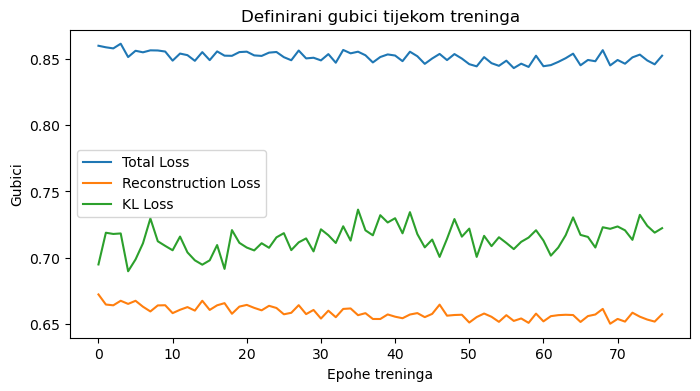

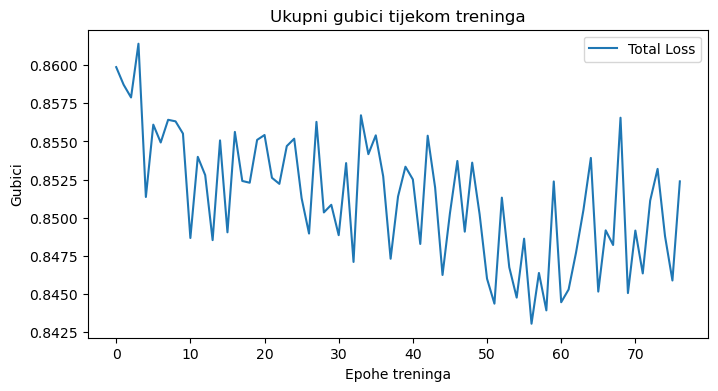

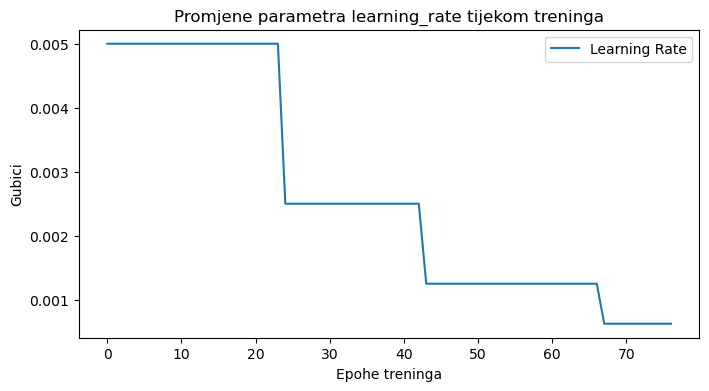

In [6]:
#VIZUALIZACIJA GUBITAKA I LEARNING RATES TIJEKOM TRENINGA

#VIzualizacija gubitaka
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.xlabel('Epohe treninga')
plt.ylabel('Gubici')
plt.title('Definirani gubici tijekom treninga')
plt.legend()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Total Loss')
plt.xlabel('Epohe treninga')
plt.ylabel('Gubici')
plt.title('Ukupni gubici tijekom treninga')
plt.legend()

#Vizualizacija learning rates
plt.figure(figsize=(8, 4))
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Epohe treninga')
plt.ylabel('Gubici')
plt.title('Promjene parametra learning_rate tijekom treninga')
plt.legend()

plt.show()

In [7]:
#Stvaranje enkodiranih i rekonstruiranih podataka za daljnje korištenje
_, _, z_input = encoder.predict(x_train)
reconstructed_z_input = vae.decoder.predict(z_input)
_, _, reconstructed_z_encoded = vae.encoder.predict(reconstructed_z_input)

_, _, z_test_input = encoder.predict(x_test)
reconstructed_z_test_input = vae.decoder.predict(z_test_input)
_, _, reconstructed_z_test_encoded = vae.encoder.predict(reconstructed_z_test_input)

66/66 [==============================] - 0s 1ms/step


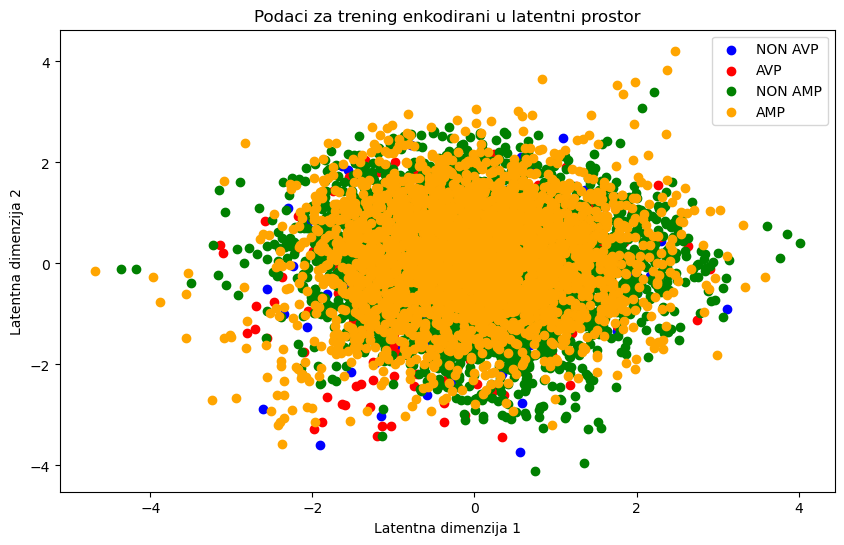

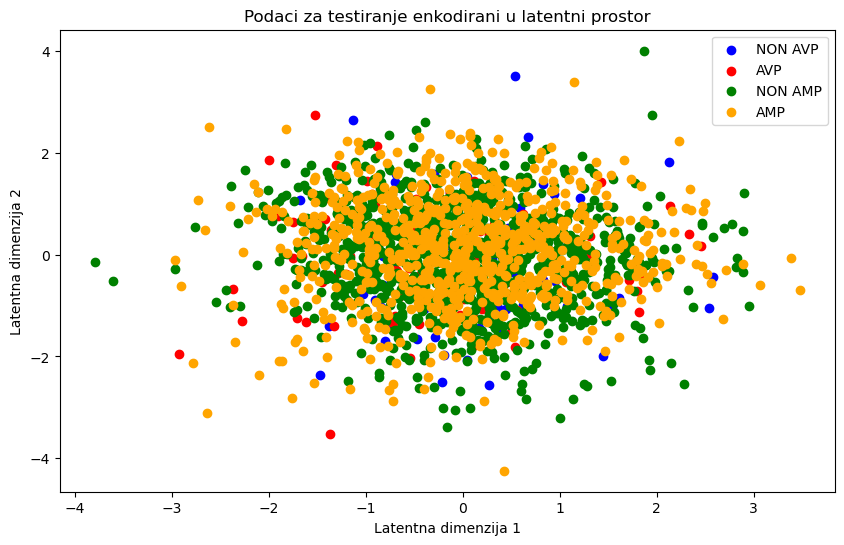

In [8]:
#Funkcija za vizualizaciju ulaznih podataka
def plot_input_data(x_data, y_data):
    z_input = x_data
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    legend_labels = ['NON AVP', 'AVP', 'NON AMP', 'AMP']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=legend_labels[label])

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()

#Vizualizacija podataka za trening i testiranje
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(z_input, y_train)

plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

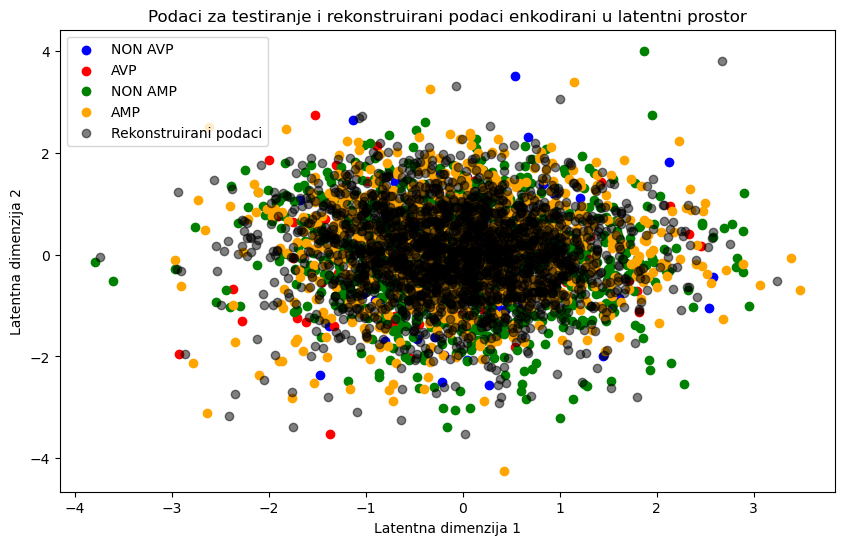

In [9]:
#Funkcija za vizualizaciju rekonstruiranih podataka preko ulaznih podataka
def plot_input_and_reconstructed_data(x_input_data, x_reconstructed, y_input_data):
    z_input = x_input_data
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    legend_labels = ['NON AVP', 'AVP', 'NON AMP', 'AMP']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=legend_labels[label])

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Rekonstruirani podaci')
    
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Podaci za testiranje i rekonstruirani podaci enkodirani u latentni prostor")
    plt.legend()
    plt.show()

plt.figure(figsize=(10, 6))
plot_input_and_reconstructed_data(z_test_input, reconstructed_z_test_encoded, y_test)


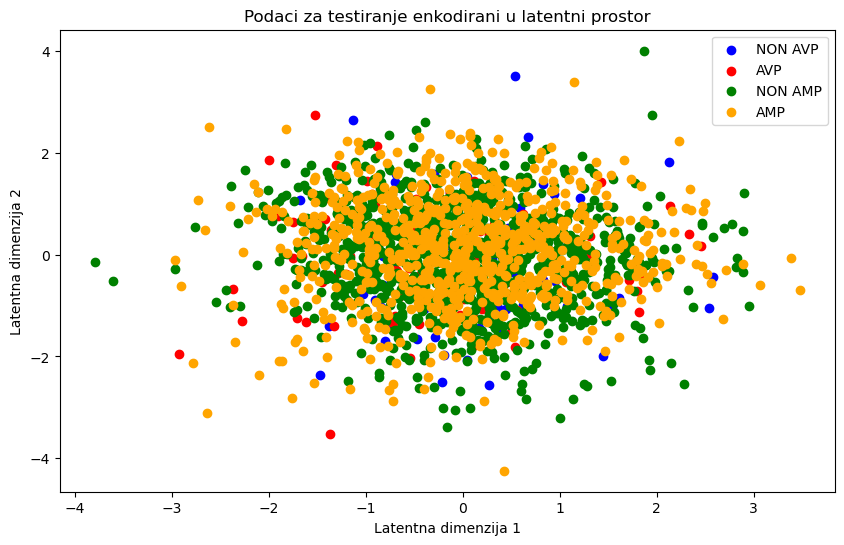

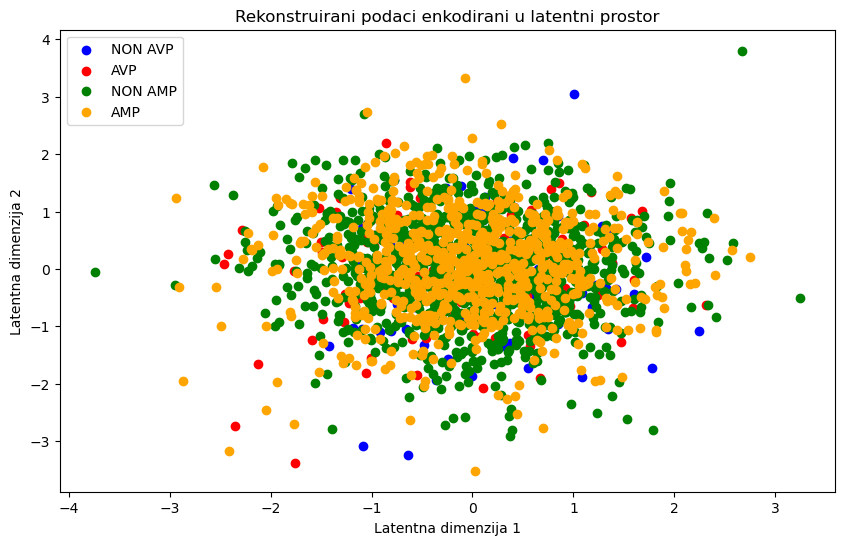

In [10]:
#Funkcija za vizualizaciju rekonstruiranih podataka
def plot_reconstructed_data(x_reconstructed, y_data):
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    legend_labels = ['NON AVP', 'AVP', 'NON AMP', 'AMP']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=legend_labels[label])
    
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
#Vizualizacija ulaznih i rekonstruiranih podataka za testiranje
plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(reconstructed_z_test_encoded, y_test)

1/1 [==============================] - 0s 18ms/step


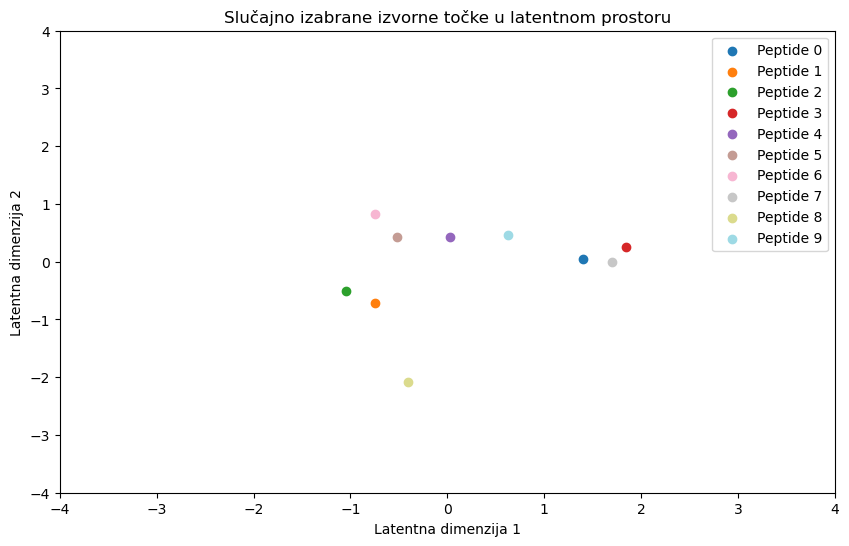

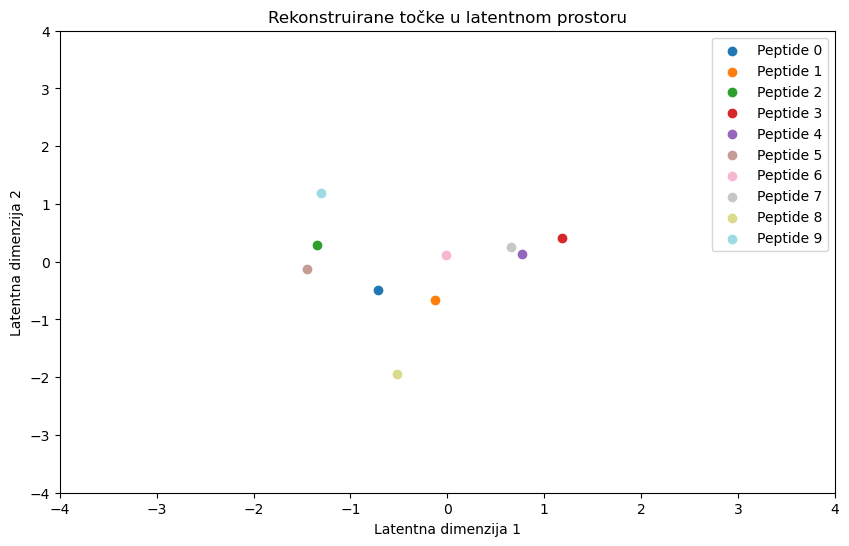

Relativna udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: 
 [2.1808, 0.62273395, 0.85458577, 0.6840054, 0.79310644, 1.0894827, 1.0218433, 1.0706656, 0.17934579, 2.0634983] 

Prosječna relativna udaljenost između izvornih i rekonstruiranih točaka:  1.0560067176818848


In [25]:
#Vizualizacija 10 nasumično izabranih peptida i njihove rekonstrukcije za usporedbu

#Odabir 10 nasumičnih peptida
selected_indices = np.random.choice(len(x_test), 10, replace=False)

selected_peptides = x_test[selected_indices]

#Enkodiranje i rekonstrukcija
_, _, encoded_selected_peptides = vae.encoder.predict(selected_peptides)
reconstructed_peptides = vae.decoder.predict(encoded_selected_peptides)
_, _, encoded_reconstructed_peptides = vae.encoder.predict(reconstructed_peptides)

#Funkcija za vizualizaciju odabranih podataka
def plot_selected_data(x_data):
    z_input = x_data
    num_peptides = z_input.shape[0]
    unique_colors = plt.cm.tab20(np.linspace(0, 1, num_peptides))

    for i in range(num_peptides):
        plt.scatter(z_input[i, 0], z_input[i, 1], color=unique_colors[i], label=f'Peptid {i}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()

#Funkcija za izračun euklidske udaljenosti     
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

#Vizualizacija odabranih peptida u izvornom i rekonstruiranom obliku
plt.figure(figsize=(10, 6))
plt.title("Slučajno izabrani izvorni peptidi u latentnom prostoru")
plot_selected_data(encoded_selected_peptides)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani peptidi u latentnom prostoru")
plot_selected_data(encoded_reconstructed_peptides)

#Izračun udaljenosti između izvornih i rekonstruiranih peptida
distances = []

for i in range(10):
    dist = euclidean_distance(encoded_selected_peptides[i], encoded_reconstructed_peptides[i])
        
    distances.append(dist)

print("Relativna udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: \n", distances, "\n")
print("Prosječna relativna udaljenost između izvornih i rekonstruiranih točaka: ", np.sum(distances)/10)

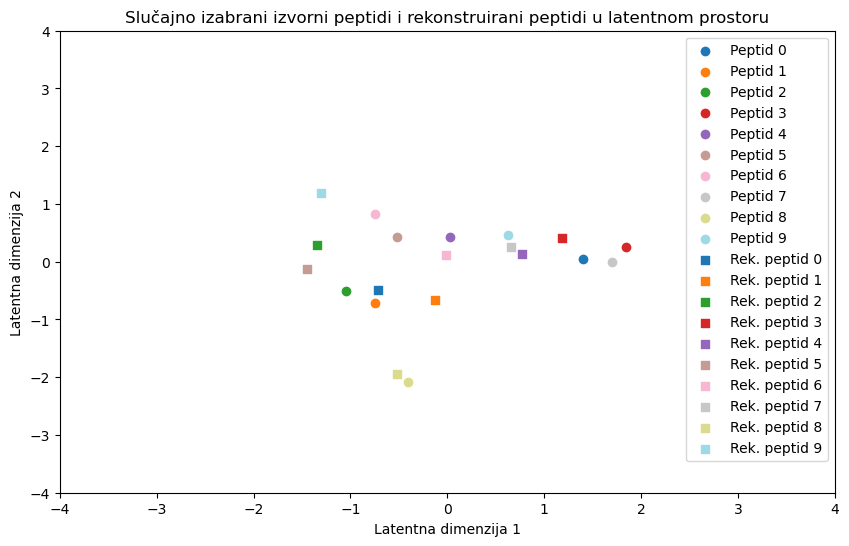

In [45]:
#VIZUALIZACIJA 10 NASUMIČNO ODABRANIH PEPTIDA I NJIHOVIH REKONSTRUKCIJA

plt.figure(figsize=(10, 6))
plt.title("Slučajno izabrani izvorni peptidi i rekonstruirani peptidi u latentnom prostoru")
unique_colors = plt.cm.tab20(np.linspace(0, 1, 10))

for i in range(10):
    plt.scatter(encoded_selected_peptides[i, 0], encoded_selected_peptides[i, 1],
                color=unique_colors[i], label=f'Peptid {i}')

for i in range(10):
    plt.scatter(encoded_reconstructed_peptides[i, 0], encoded_reconstructed_peptides[i, 1],
                marker='s', color=unique_colors[i], label=f'Rek. peptid {i}')

ax = plt.gca()
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
plt.xlabel("Latentna dimenzija 1")
plt.ylabel("Latentna dimenzija 2")
plt.legend()
plt.show()

In [12]:
#NORMALIZIRANA UDALJENOST REKONSTRUKCIJE U LATENTNOM PROSTORU

min_values = np.min(z_test_input, axis=0)
max_values = np.max(z_test_input, axis=0)

latent_space_size = np.linalg.norm(max_values - min_values)

print(latent_space_size)

distances_x_test = []

for i in range(len(x_test)):
    dist = euclidean_distance(z_test_input[i], reconstructed_z_test_encoded[i])
        
    distances_x_test.append(dist)

print("Normalizirana prosječna udaljenost između izvornih i rekonstruiranih točaka: ", 
      np.sum(distances_x_test)/latent_space_size/len(x_test))

10.994248
Normalizirana prosječna udaljenost između izvornih i rekonstruiranih točaka:  0.10137692920108599


In [13]:
#PEARSONOV KOEFICIJENT KORELACIJE

from scipy.stats import spearmanr, kendalltau, pearsonr

print(pearsonr(x_test.flatten(), reconstructed_z_test_input.flatten()))

PearsonRResult(statistic=0.793097297028114, pvalue=0.0)


In [14]:
#RMSE

mse = np.mean(np.square(x_test - reconstructed_z_test_input))
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")


RMSE: 0.08663831325057528


In [15]:
#IZRAČUN SLIČNOSTI PEPTIDA PREMA SEKVENCI
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
  
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    alignments = pairwise2.align.globalxx(seq1, seq2)

    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    similarity = (score / max(len(seq1), len(seq2)))

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,101):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.39534884 0.18604651 0.34883721]
 [0.1025641  0.         0.12820513 ... 0.13157895 0.125      0.05263158]
 [0.20512821 0.28       0.23076923 ... 0.18421053 0.32       0.23684211]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.34210526 0.32432432 0.34210526]
 [0.33333333 0.17777778 0.26666667 ... 0.33333333 0.22222222 0.33333333]
 [0.07692308 0.25       0.15384615 ... 0.18421053 0.16666667 0.23684211]]
[[0.27272727 0.18604651 0.27906977 ... 0.27906977 0.20930233 0.30232558]
 [0.36363636 0.25581395 0.27906977 ... 0.3255814  0.1627907  0.18604651]
 [0.25       0.17241379 0.26666667 ... 0.14285714 0.3        0.2       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.26190476 0.28571429 0.14285714]
 [0.34090909 0.2972973  0.54054054 ... 0.28571429 0.24324324 0.2972973 ]
 [0.09090909 0.13793103 0.06666667 ... 0.0952381  0.17647059 0.2       ]]


In [16]:
#IZRAČUN SLIČNOSTI PEPTIDA PREMA UDALJENOSTI U LATENTNOM PROSTORU
distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,101):
        dist_train = euclidean_distance(z_input[i], z_input[j])
        dist_test = euclidean_distance(z_test_input[i], z_test_input[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.11085266 0.26828107 0.09316999 ... 0.325491   0.15543154 0.29661566]
 [0.8499131  0.891466   0.8135954  ... 0.74201816 0.8602467  0.88622016]
 [0.         0.15873489 0.25053933 ... 0.4634382  0.         0.14349592]
 ...
 [0.14406195 0.3466293  0.21206476 ... 0.15001579 0.16258717 0.24887   ]
 [0.42699322 0.5688289  0.36385593 ... 0.10242385 0.45065382 0.5203104 ]
 [0.39204037 0.54185355 0.33380872 ... 0.05913818 0.41589195 0.48777843]]
[[0.6534919  0.42920697 0.38783497 ... 0.55731404 0.5526494  0.31823707]
 [0.610336   0.04578775 0.70850086 ... 0.38986856 0.79186565 0.6940765 ]
 [0.8111313  0.672233   0.53036094 ... 0.7537237  0.71958387 0.12722868]
 ...
 [0.29961568 0.33448952 0.06700267 ... 0.29860467 0.07135092 0.4296565 ]
 [0.5165217  0.3413838  0.24151635 ... 0.43366933 0.37785774 0.3667543 ]
 [0.68172646 0.8015646  0.44486126 ... 0.74376434 0.567629   0.10013081]]


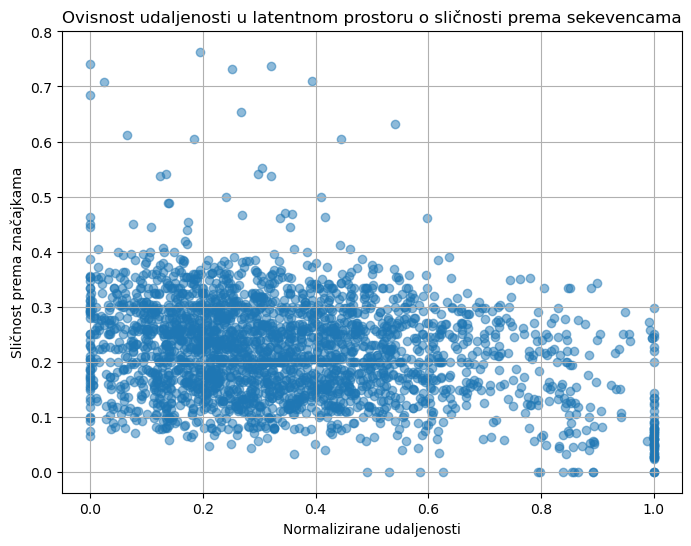

In [17]:
#VIZUALIZACIJA OVISNOSTI UDALJENOSTI U LATENTNOM PROSTORU O SLIČNOSTI PREMA SEKVENCAMA

flat_normalized_distances_train = normalized_distances_train.flatten()
flat_similarities_train = similarities_train.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(flat_normalized_distances_train, flat_similarities_train, alpha=0.5)
plt.title("Ovisnost udaljenosti u latentnom prostoru o sličnosti prema sekevencama")
plt.xlabel("Normalizirane udaljenosti")
plt.ylabel("Sličnost prema značajkama")
plt.grid(True)
plt.show()

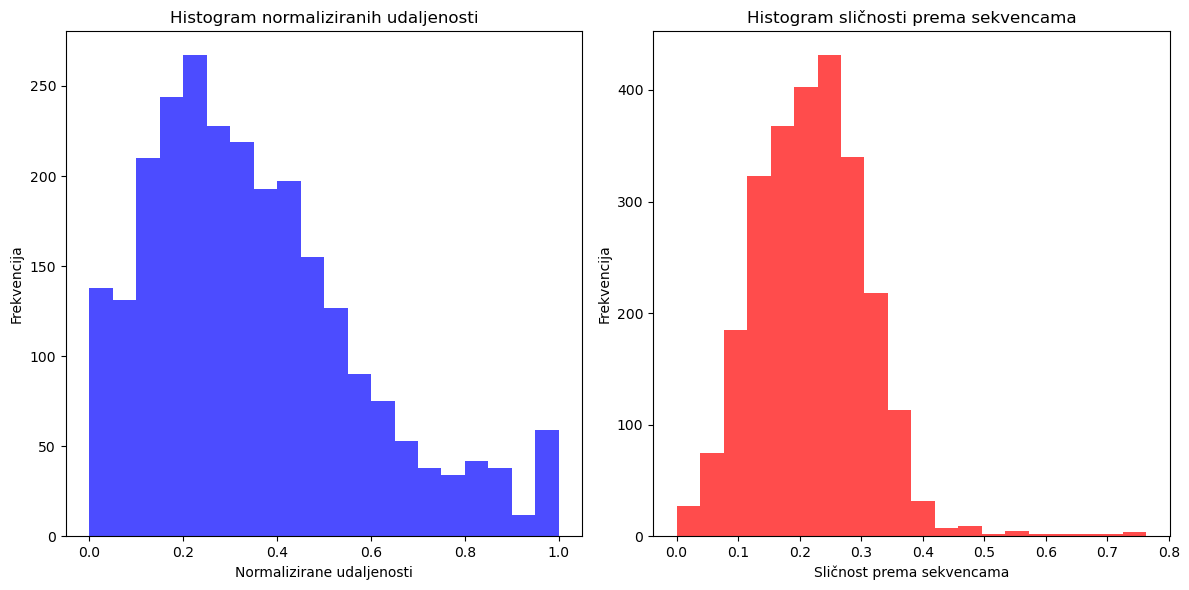

In [18]:
#VIZUALIZACIJA DISTRIBUCIJE UDALJENOSTI U LATENTNOM PROSTORU O SLIČNOSTI PREMA ZNAČAJKAMA

plt.figure(figsize=(12, 6))

#Histogram udaljenosti
plt.subplot(1, 2, 1)
plt.hist(flat_normalized_distances_train, bins=20, color='blue', alpha=0.7)
plt.title("Histogram normaliziranih udaljenosti")
plt.xlabel("Normalizirane udaljenosti")
plt.ylabel("Frekvencija")

#Histogram sličnosti prema sekvenci
plt.subplot(1, 2, 2)
plt.hist(flat_similarities_train, bins=20, color='red', alpha=0.7)
plt.title("Histogram sličnosti prema sekvencama")
plt.xlabel("Sličnost prema sekvencama")
plt.ylabel("Frekvencija")

plt.tight_layout()
plt.show()


In [19]:
#KORELACIJSKA ANALIZA

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.31780268436946146 -0.2380752950992034
p-value: 6.107721449634498e-61 3.427708422068381e-34 



In [20]:
sum_train = 0
sum_test = 0
pval_train = 0
pval_test = 0

N = 50

for x in range(10):
    
    similarities_train = []
    similarities_test = []

    for i in range(N-50,N):
        row_similarities_train = []
        row_similarities_test = []
        for j in range(N,N+51):
            sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])
            sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])
            row_similarities_train.append(sim_train)
            row_similarities_test.append(sim_test)

        similarities_train.append(row_similarities_train)
        similarities_test.append(row_similarities_test)

    similarities_train = np.array(similarities_train)
    similarities_test = np.array(similarities_test)

    
    distances_train = []
    distances_test = []

    for i in range(N-50,N):
        row_distances_train = []
        row_distances_test = []
        for j in range(N,N+51):
            dist_train = euclidean_distance(z_input[i], z_input[j])
            dist_test = euclidean_distance(z_test_input[i], z_test_input[j])
            row_distances_train.append(dist_train)
            row_distances_test.append(dist_test)

        distances_train.append(row_distances_train)
        distances_test.append(row_distances_test)

    distances_train = np.array(distances_train)
    distances_test = np.array(distances_test)

    normalized_distances_train = scaler.fit_transform(distances_train)
    normalized_distances_test = scaler.fit_transform(distances_test)

    correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
    correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())
    
    print("Rezultati ispitivanja pod rednim brojem ", x+1, ":\n")
    print("Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
    print("p-value:", p_value_train, p_value_test, "\n")
    
    sum_train += correlation_train
    sum_test += correlation_test
    pval_train += p_value_train
    pval_test += p_value_test

    N += 50

print("Konačni rezultati ispitivanja:")
print("Usrednjeni koeficijent korelacije za skupove podataka za trening i testiranje: \n", sum_train/10, sum_test/10)
print("p-value:", pval_train/10, pval_test/10, "\n")

Rezultati ispitivanja pod rednim brojem  1 :

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.31780268436946146 -0.2380752950992034
p-value: 6.107721449634498e-61 3.427708422068381e-34 

Rezultati ispitivanja pod rednim brojem  2 :

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.20338237237250362 -0.23848983761168424
p-value: 3.2602868996097305e-25 2.620428481749512e-34 

Rezultati ispitivanja pod rednim brojem  3 :

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.21359367108107719 -0.14655529246982868
p-value: 1.0699974120807022e-27 1.0281034511551299e-13 

Rezultati ispitivanja pod rednim brojem  4 :

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.294163297521674 -0.30733353401060204
p-value: 4.484506257977129e-52 6.51071248946091e-57 

Rezultati ispitivanja pod rednim brojem  5 :

Pearsonov koeficijent korelacije za skupove podataka za trening